In [24]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt

# Цель занятия
На этом занятии мы рассмотрим особенности реализации алгоритмов кластеризации и снижения размерности.

## K-Means

K-means (к-средних) — это алгоритм кластеризации, который используется для разделения набора данных на группы (кластеры) на основе их схожести. Алгоритм старается минимизировать суммарное квадратичное отклонение между точками внутри каждого кластера и центроидами (средними значениями) этих точек.

Процесс работы алгоритма k-средних следующий:

1. Инициализация: Выбирается количество кластеров k и случайно инициализируются k центроидов.
2. Присваивание точек к кластерам: Каждая точка данных присваивается к ближайшему центроиду на основе евклидова расстояния или другой метрики.
3. Пересчет центроидов: Вычисляются новые центроиды путем нахождения средних значений точек в каждом кластере.
4. Повторение шагов 2 и 3: Шаги 2 и 3 повторяются до сходимости алгоритма, то есть до тех пор, пока точки перестают изменять свою принадлежность к кластерам или достигнут предел максимального количества итераций.

В результате работы алгоритма k-средних мы получаем k кластеров, в каждом из которых точки схожи между собой и отличаются от точек в других кластерах. Кластеризация данных с помощью k-средних может быть полезна для группировки и классификации данных, выявления скрытых закономерностей и понимания структуры данных.

In [2]:
def kmeans(X, K, max_iters=100):
    # Инициализация центроидов случайным образом
    centroids = X[np.random.choice(range(len(X)), K, replace=False)]
    
    for _ in range(max_iters):
        # Нахождение ближайшего центроида для каждой точки
        labels = np.argmin(np.linalg.norm(X[:, np.newaxis] - centroids, axis=-1), axis=-1)
        
        # Обновление центроидов
        new_centroids = np.array([X[labels == k].mean(axis=0) for k in range(K)])
        
        # Проверка условия сходимости
        if np.all(centroids == new_centroids):
            break
        
        centroids = new_centroids
    
    return centroids, labels

In [3]:
# Пример использования
X = np.array([[1, 2], [1.5, 1.8], [5, 8], [8, 8], [1, 0.6], [9, 11]])
K = 2

centroids, labels = kmeans(X, K)
print("Центроиды:")
print(centroids)
print("Метки кластеров:")
print(labels)

Центроиды:
[[1.16666667 1.46666667]
 [7.33333333 9.        ]]
Метки кластеров:
[0 0 1 1 0 1]


## DBSCAN

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) - это алгоритм кластеризации данных, основанный на плотности. Он идентифицирует кластеры, исходя из плотности точек в пространстве данных, а также обнаруживает выбросы, которые не принадлежат ни к одному кластеру.

Процесс работы алгоритма DBSCAN следующий:

1. Выбор начальной точки: Выбирается случайная точка, которая еще не была посещена и не является выбросом.
2. Поиск плотной области: Алгоритм расширяется от выбранной начальной точки, посещая ближайшие точки в заданном радиусе epsilon. Если в заданной окрестности (эпсилон-окрестности) находится минимальное количество точек, необходимое для формирования кластера, то точка считается ядром (core point).
3. Расширение кластера: Для каждого ядра образуется кластер, который включает все точки, достижимые из этого ядра в заданном радиусе epsilon. Для этого рекурсивно ищутся все плотные точки в окрестности ядра.
4. Поиск выбросов: Точки, которые не достижимы из ядерных точек, считаются выбросами (noise points). Они не принадлежат ни к одному кластеру.
5. Повторение шагов 2-4: Шаги 2-4 повторяются для всех непосещенных точек данных до тех пор, пока все точки не будут просмотрены.

В результате работы алгоритма DBSCAN получаем кластеры различной формы и размеров. Кластеры определяются на основе плотности точек в пространстве данных, а не на основе евклидова расстояния. Это позволяет DBSCAN обнаруживать кластеры произвольной формы и корректно обрабатывать выбросы. Алгоритм DBSCAN может быть особенно полезен в задачах, где кластеры имеют различную плотность или форму, или когда необходимо обнаружить выбросы и шум в данных.

In [4]:
class DBSCAN:
    def __init__(self, eps, min_samples):
        self.eps = eps
        self.min_samples = min_samples
        self.labels = None
    
    def euclidean_distance(self, x1, x2):
        return np.sqrt(np.sum((x1 - x2) ** 2))
    
    def fit(self, X):
        self.labels = np.zeros(len(X))  # Инициализируем массив меток кластера нулями для каждой точки в датасете
        cluster_label = 0  # Инициализируем счетчик меток кластера

        for i in range(len(X)):  # Проходим по всем точкам в датасете
            if self.labels[i] != 0:  # Если точка уже имеет метку кластера, переходим к следующей точке
                continue

            neighbors = self._find_neighbors(X, i)  # Находим соседей для текущей точки

            if len(neighbors) < self.min_samples:  # Если количество соседей меньше минимального требования
                self.labels[i] = -1  # Присваиваем точке метку выброса (-1)
            else:
                cluster_label += 1  # Инкрементируем счетчик меток кластера
                self._expand_cluster(X, i, neighbors, cluster_label)  # Расширяем кластер, начиная с текущей точки

    
    def _expand_cluster(self, X, point_index, neighbors, cluster_label):
        """
        В этом методе сначала присваивается выбранной точке `point_index` метка кластера `cluster_label`.

        Затем идет цикл `while`, который выполняется, пока не исчерпаны все соседи в списке `neighbors`.

        На каждой итерации цикла берется очередной сосед из списка `neighbors` и проверяется его метка кластера:

        - Если метка равна `-1`, это означает, что сосед не имеет метки кластера. 
            В этом случае ему присваивается метка кластера `cluster_label`.
        - Если метка равна `0`, это означает, что сосед не принадлежит ни одному кластеру. 
            В этом случае ему также присваивается метка кластера `cluster_label`. 
        Затем для этого соседа находятся новые соседи с помощью метода `_find_neighbors`.
            - Если количество новых соседей больше или равно минимальному требованию `min_samples`, 
                то эти новые соседи добавляются в список `neighbors`.

        В конце каждой итерации цикла инкрементируется счетчик `i` для перехода к следующему 
        соседу в списке `neighbors`.
        
        """
        self.labels[point_index] = cluster_label  # Присваиваем метку кластера выбранной точке

        i = 0
        while i < len(neighbors):  # Пока не исчерпаны все соседи
            neighbor = neighbors[i]  # Берем очередного соседа

            if self.labels[neighbor] == -1:  # Если сосед не имеет метки кластера
                self.labels[neighbor] = cluster_label  # Присваиваем ему метку кластера
            elif self.labels[neighbor] == 0:  # Если сосед не принадлежит ни одному кластеру
                self.labels[neighbor] = cluster_label  # Присваиваем ему метку кластера
                new_neighbors = self._find_neighbors(X, neighbor)  # Находим новых соседей для данной точки

                if len(new_neighbors) >= self.min_samples:  # Если количество новых соседей больше или равно минимальному требованию
                    neighbors += new_neighbors  # Добавляем новых соседей в список соседей
            i += 1  # Переходим к следующему соседу

    
    def _find_neighbors(self, X, point_index):
        # Инициализируем пустой список для хранения индексов соседних точек
        neighbors = []  
        for i in range(len(X)):  # Проходим по всем точкам в датасете
            # Если расстояние между текущей точкой и точкой с индексом i меньше или равно eps
            if self.euclidean_distance(X[point_index], X[i]) <= self.eps:  
                neighbors.append(i)  # Добавляем индекс соседней точки в список neighbors
        return neighbors  # Возвращаем список соседних точек


In [5]:
# Пример использования
X = np.array([[1, 2], [1.5, 1.8], [5, 8], [8, 8], [1, 0.6], [9, 11]])
eps = 2
min_samples = 2

dbscan = DBSCAN(eps, min_samples)
dbscan.fit(X)

print("Метки кластеров:")
print(dbscan.labels)

Метки кластеров:
[ 1.  1. -1. -1.  1. -1.]


## Агломеративная кластеризация

Агломеративная кластеризация (агломеративный метод) - это алгоритм иерархической кластеризации, который последовательно объединяет близкие точки данных в кластеры, формируя дерево иерархии кластеров, называемое дендрограммой.

Процесс работы агломеративной кластеризации следующий:

1. Инициализация: Каждая точка данных начинает в качестве отдельного кластера.
2. Вычисление матрицы расстояний: Вычисляется матрица расстояний между каждой парой кластеров. Расстояние может быть определено различными способами, такими как евклидово расстояние или корреляция.
3. Объединение ближайших кластеров: Два ближайших кластера (т.е. с наименьшим расстоянием между ними) объединяются в один новый кластер.
4. Обновление матрицы расстояний: Матрица расстояний обновляется, чтобы отразить расстояния между новым объединенным кластером и остальными кластерами.
5. Повторение шагов 3 и 4: Шаги 3 и 4 повторяются до тех пор, пока все точки данных не объединятся в один кластер или достигнется заранее заданное количество кластеров.
6. Построение дендрограммы: На основе последовательности объединений строится дендрограмма, которая визуализирует иерархию кластеров.

Результат агломеративной кластеризации представляет собой дерево иерархии кластеров, где каждый узел представляет собой кластер, а расстояние между узлами отображает степень их схожести. По анализу дендрограммы можно определить оптимальное количество кластеров, а также их структуру и иерархические отношения. Агломеративная кластеризация особенно полезна в задачах, где требуется иерархическое представление кластеров или когда количество кластеров неизвестно заранее.

In [6]:
class AgglomerativeClustering:
    def __init__(self, n_clusters):
        self.n_clusters = n_clusters
        self.labels = None
    
    def fit(self, X):
        # Инициализация каждой точки как отдельного кластера
        clusters = [[x] for x in X]

        while len(clusters) > self.n_clusters:  # Пока количество кластеров больше заданного числа
            min_dist = np.inf  # Инициализация минимального расстояния как бесконечность
            merge_indices = (0, 0)  # Инициализация индексов кластеров для объединения

            # Находим два ближайших кластера для объединения
            for i in range(len(clusters)):  # Проходим по каждому кластеру
                for j in range(i+1, len(clusters)):  # Проходим по остальным кластерам
                    dist = self._distance(clusters[i], clusters[j])  # Вычисляем расстояние между кластерами

                    if dist < min_dist:  # Если текущее расстояние меньше минимального
                        min_dist = dist  # Обновляем значение минимального расстояния
                        merge_indices = (i, j)  # Обновляем индексы кластеров для объединения

            # Объединяем два ближайших кластера
            merged_cluster = clusters[merge_indices[0]] + clusters[merge_indices[1]]

            # Удаляем объединенные кластеры из списка
            del clusters[merge_indices[1]]
            del clusters[merge_indices[0]]

            # Добавляем объединенный кластер в список
            clusters.append(merged_cluster)

        # Присваиваем метки кластеров точкам
        self.labels = self._assign_labels(clusters, X)

    
    def _distance(self, cluster1, cluster2):
        min_dist = np.inf  # Инициализируем переменную минимального расстояния как бесконечность

        for point1 in cluster1:  # Проходим по каждой точке в первом кластере
            for point2 in cluster2:  # Проходим по каждой точке во втором кластере
                dist = np.linalg.norm(point1 - point2)  # Вычисляем Евклидово расстояние между двумя точками
                if dist < min_dist:  # Если текущее расстояние меньше минимального
                    min_dist = dist  # Обновляем значение минимального расстояния

        return min_dist  # Возвращаем минимальное расстояние

    
    def _assign_labels(self, clusters, dataset):
        labels = np.zeros(dataset.shape[0], dtype=int)  # Заполняем для каждой точки массив меток нулями

        for index, point in enumerate(dataset):  # Проходим по каждой  точке в датасете
            for cluster_index, cluster in enumerate(clusters): # Проходим по всем кластерам
                if np.sum(np.all(cluster == point, axis=1)): # Проверяем вхождение точки в текущий кластер
                    labels[index] = cluster_index  # Присваиваем метку кластера текущей точке
                    continue

        return labels  # Возвращаем массив меток


In [7]:
# Пример использования
X = np.array([[1, 2], [1.5, 1.8], [5, 8], [8, 8], [1, 0.6], [9, 11]])
n_clusters = 2

agglomerative = AgglomerativeClustering(n_clusters)
agglomerative.fit(X)

print("Метки кластеров:")
print(agglomerative.labels)

Метки кластеров:
[0 0 1 1 0 1]


## PCA 

PCA(Principal Component Analysis) - это метод снижения размерности данных, который используется для выявления наиболее информативных признаков в наборе данных и проекции их на новое пространство меньшей размерности. Основная цель PCA - найти линейные комбинации исходных признаков, называемые главными компонентами, которые содержат наибольшую дисперсию в данных.

Процесс работы PCA следующий:

1. Стандартизация данных: Исходные признаки стандартизируются, чтобы они имели среднее значение равное 0 и стандартное отклонение равное 1. Это делается для того, чтобы признаки с различными единицами измерения не искажали результаты анализа.
2. Вычисление матрицы ковариации: Вычисляется матрица ковариации, которая показывает связи исходных признаков друг с другом. Ковариация измеряет, насколько два признака меняются вместе.
3. Вычисление собственных значений и собственных векторов: Собственные значения и собственные векторы извлекаются из матрицы ковариации. Собственные значения представляют собой меру дисперсии вдоль соответствующих собственных векторов.
4. Сортировка главных компонент: Главные компоненты сортируются по убыванию их собственных значений. Главная компонента с наибольшим собственным значением содержит наибольшую дисперсию в данных.
5. Выбор количества главных компонент: Определяется количество главных компонент, которые будут использоваться для проекции данных на новое пространство. Можно выбрать определенное количество компонент или определить процент дисперсии, которую они объясняют.
6. Проекция данных: Исходные признаки проецируются на выбранные главные компоненты, формируя новое пространство с меньшей размерностью.

Результат PCA - это новое пространство признаков с меньшей размерностью, где каждая главная компонента представляет собой линейную комбинацию исходных признаков. Главные компоненты упорядочены по убыванию их значимости, и первые компоненты содержат наибольшую долю дисперсии в данных. PCA широко используется для визуализ

ации данных, устранения мультиколлинеарности, сжатия данных и улучшения производительности алгоритмов машинного обучения путем снижения размерности пространства признаков.

In [8]:
class PCA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.components = None
        self.mean = None
    
    def fit(self, X):
        # Вычисляем среднее значение каждого признака
        self.mean = np.mean(X, axis=0)
        
        # Центрируем данные путем вычитания среднего
        X_centered = X - self.mean
        
        # Вычисляем матрицу ковариации
        covariance_matrix = np.cov(X_centered.T)
        
        # Вычисляем собственные значения и собственные векторы
        eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
        
        # Сортируем собственные значения и соответствующие собственные векторы в порядке убывания
        eigen_indices = np.argsort(eigenvalues)[::-1]
        sorted_eigenvectors = eigenvectors[:, eigen_indices]
        
        # Выбираем первые n_components собственных векторов
        self.components = sorted_eigenvectors[:, :self.n_components]
    
    def transform(self, X):
        # Центрируем данные путем вычитания среднего
        X_centered = X - self.mean
        
        # Проецируем данные на главные компоненты
        transformed = np.dot(X_centered, self.components)
        
        return transformed

In [9]:
# Пример использования
X = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]])
n_components = 2

pca = PCA(n_components)
pca.fit(X)

transformed = pca.transform(X)
print("Преобразованные данные:")
print(transformed)

Преобразованные данные:
[[-7.79422863e+00 -2.77555756e-16]
 [-2.59807621e+00  5.55111512e-17]
 [ 2.59807621e+00 -5.55111512e-17]
 [ 7.79422863e+00  2.77555756e-16]]


## t-SNE 

t-SNE (t-Distributed Stochastic Neighbor Embedding) - это метод снижения размерности данных, который используется для визуализации сложных структур данных и обнаружения скрытых паттернов. В отличие от PCA, t-SNE обеспечивает сохранение не только линейной структуры данных, но и нелинейных отношений между точками.

Процесс работы t-SNE следующий:

1. Вычисление аффинности: Сначала вычисляется аффинность (похожесть) между парами точек данных. Это может быть сделано с использованием Гауссовой функции, основанной на расстоянии между точками в исходном пространстве.
2. Вычисление условной вероятности: Для каждой точки данных вычисляется условная вероятность, которая показывает вероятность выбрать другую точку в качестве соседа, исходя из аффинности. Более похожие точки имеют более высокие вероятности быть выбранными в качестве соседей.
3. Определение сходства в пространстве низкой размерности: Для пространства низкой размерности (обычно 2D) исходные точки данных и их аффинности переопределяются с использованием условных вероятностей. Это позволяет сохранить близость точек, имеющих высокую аффинность в исходном пространстве.
4. Минимизация дивергенции Кульбака-Лейблера: t-SNE оптимизирует распределение точек в пространстве низкой размерности, минимизируя дивергенцию Кульбака-Лейблера между условными вероятностями точек в исходном пространстве и пространстве низкой размерности.
5. Итерационная оптимизация: Алгоритм итеративно обновляет расположение точек в пространстве низкой размерности, чтобы минимизировать дивергенцию Кульбака-Лейблера. Оптимизация основывается на градиентных методах или методах случайного блуждания.

Результат t-SNE представляет собой вложение точек в пространство низкой размерности, где близкие точки соответствуют точкам с высокой аффинностью в исходном пространстве. t-SNE обладает способностью выявлять сложные нелинейные структуры и класт

еры в данных, что делает его полезным для визуализации и понимания сложных наборов данных. Однако важно отметить, что расположение точек в пространстве низкой размерности может быть чувствительным к различным параметрам и инициализации, поэтому результаты t-SNE требуют внимательного анализа и интерпретации.

In [20]:
class TSNE:
    def __init__(self, n_components, perplexity=30, learning_rate=200, n_iter=1000, use_history=False):
        self.n_components = n_components
        self.perplexity = perplexity
        self.learning_rate = learning_rate
        self.n_iter = n_iter
        self.embedding = None
        self.use_history = use_history
        self.history = []
    
    def fit(self, X):
        np.random.seed(0)  # Установка начального состояния генератора случайных чисел
        self.embedding = np.random.normal(0, 1e-4, (X.shape[0], self.n_components))
        # Инициализация матрицы вложений с помощью случайных значений из нормального распределения

        pairwise_distances = self._pairwise_distances(X)  # Вычисление попарных расстояний между точками

        P = self._compute_conditional_probabilities(pairwise_distances)
        # Вычисление матрицы условных вероятностей P на основе попарных расстояний

        Y = np.random.normal(0, 1e-4, (X.shape[0], self.n_components))
        # Инициализация матрицы Y с помощью случайных значений из нормального распределения

        for _ in range(self.n_iter):
            Q = self._compute_joint_probabilities(Y)  # Вычисление матрицы совместных вероятностей Q
            grad = self._gradient(P, Q, Y)  # Вычисление градиента
            Y = Y - self.learning_rate * grad  # Обновление матрицы Y с помощью градиентного спуска
            if self.use_history:
                self.history.append(Y)

        self.embedding = Y  # Присваивание полученных вложений матрице self.embedding


    
    def _pairwise_distances(self, X):
        sum_X = np.sum(np.square(X), axis=1)  # Вычисление суммы квадратов элементов по строкам матрицы X
        pairwise_distances = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
        # Вычисление попарных евклидовых расстояний между точками:
        # - Вычисление произведения матрицы X на транспонированную матрицу X и умножение его на -2.
        # - Добавление суммы квадратов элементов по строкам матрицы X к полученной матрице.
        # - Транспонирование матрицы и добавление суммы квадратов элементов по строкам матрицы X к каждому столбцу.

        pairwise_distances = np.maximum(pairwise_distances, 0)  # Замена отрицательных значений на нули

        return pairwise_distances  # Возвращение матрицы попарных расстояний


    
    def _compute_conditional_probabilities(self, distances):
        P = np.zeros((distances.shape[0], distances.shape[0]))  # Инициализация матрицы условных вероятностей P

        for i in range(distances.shape[0]):
            sorted_indices = np.argsort(distances[i])[1:self.perplexity+1]  # Индексы k ближайших соседей, отсортированных по возрастанию расстояния
            Di = distances[i, sorted_indices]  # Расстояния до k ближайших соседей
            Hi = self._binary_search_perplexity(Di)  # Вычисление условной вероятности Hi на основе бинарного поиска perplexity
            P[i, sorted_indices] = Hi  # Присваивание найденных условных вероятностей Hi в соответствующие ячейки матрицы P

        P = (P + P.T) / (2 * distances.shape[0])  # Симметризация матрицы P и нормализация
        P = np.maximum(P, 1e-12)  # Устранение нулевых значений и сглаживание

        return P  # Возвращение матрицы условных вероятностей P

    
    def _binary_search_perplexity(self, Di):
        beta = 1.0  # Инициализация параметра бета для двоичного поиска
        desired_entropy = np.log2(self.perplexity)  # Желаемая энтропия, вычисленная на основе perplexity
        min_beta = -np.inf  # Минимальное значение бета
        max_beta = np.inf  # Максимальное значение бета
        tolerance = 1e-5  # Допустимая погрешность

        for _ in range(50):
            sum_Pi = np.sum(np.exp(-beta * Di))  # Сумма условных вероятностей Pi
            Hi = np.log2(sum_Pi) + beta * np.sum(Di * np.exp(-beta * Di)) / sum_Pi
            # Вычисление энтропии Hi на основе текущего значения бета:
            # - Вычисляем сумму экспонент -beta * Di и записываем ее в sum_Pi.
            # - Вычисляем Hi путем сложения логарифма sum_Pi и выражения beta * np.sum(Di * np.exp(-beta * Di)) / sum_Pi.

            entropy_diff = Hi - desired_entropy  # Разница между текущей и желаемой энтропией

            if np.abs(entropy_diff) <= tolerance:
                break  # Если разница между энтропиями меньше или равна допустимой погрешности, выходим из цикла

            if entropy_diff > 0:
                max_beta = beta  # Если разница положительная, ограничиваем максимальное значение бета
                if np.isinf(min_beta):
                    beta *= 2  # Если минимальное значение бета равно отрицательной бесконечности, удваиваем бета
                else:
                    beta = (beta + min_beta) / 2  # Иначе, вычисляем новое значение бета как среднее между текущим и минимальным значением бета
            else:
                min_beta = beta  # Если разница отрицательная, ограничиваем минимальное значение бета
                if np.isinf(max_beta):
                    beta /= 2  # Если максимальное значение бета равно положительной бесконечности, делаем бета в два раза меньше
                else:
                    beta = (beta + max_beta) / 2  # Иначе, вычисляем новое значение бета как среднее между текущим и максимальным значением бета

        return np.exp(-beta * Di)  # Возвращаем условную вероятность Pi, вычисленную на основе окончательного значения бета


    
    def _compute_joint_probabilities(self, Y):
        sum_Y = np.sum(np.square(Y), axis=1)  # Сумма квадратов координат точек в низкоразмерном пространстве
        pairwise_distances = np.add(np.add(-2 * np.dot(Y, Y.T), sum_Y).T, sum_Y)
        # Расстояния между точками в низкоразмерном пространстве.
        # -2 * np.dot(Y, Y.T) вычисляет скалярное произведение между всеми парами точек в низкоразмерном пространстве.
        # Суммируя сумму квадратов координат исходных точек (sum_Y), получаем расстояния.

        pairwise_distances = np.maximum(pairwise_distances, 1e-12)  # Предотвращение деления на ноль

        Q = 1 / pairwise_distances  # Вычисление совместной вероятности Q
        np.fill_diagonal(Q, 0)  # Установка нулей на диагонали, чтобы исключить вероятности точек самих с собой
        Q /= np.sum(Q)  # Нормализация вероятностей, чтобы их сумма составляла 1

        return Q  # Возвращаем совместную вероятность Q

    
    def _gradient(self, P, Q, Y):

        n = len(P)
        gradient = np.zeros(shape=(n, Y.shape[1]))
        for i in range(0, n):
            # Разница между координатами текущей точки Y[i] и всеми остальными точками Y
            diff = Y[i] - Y
            # Разница между матрицами условных вероятностей P[i] и совместной вероятности Q[i]
            A = np.array([(P[i, :] - Q[i, :])])
            # Вычисление значения B, используя расстояния между точками в низкоразмерном пространстве
            B = np.array([(1 + np.linalg.norm(diff, axis=1))**(-1)])
            # Разница между координатами текущей точки Y[i] и всеми остальными точками Y
            C = diff
            # Вычисление градиента для текущей точки
            gradient[i] = 4 * np.sum((A * B).T * C, axis=0)

        return gradient



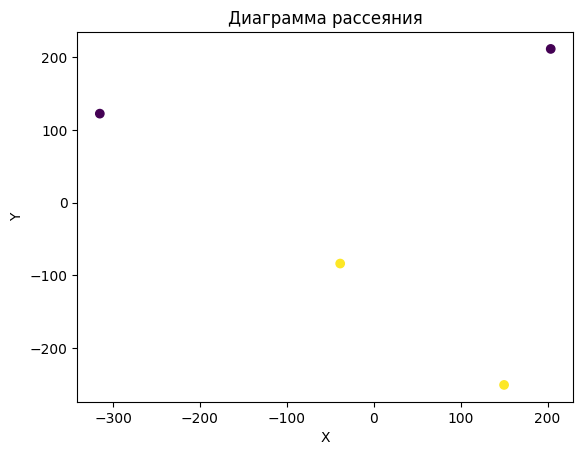

In [51]:
# Пример использования
X = np.array([[1, 1, 1], [2, 2, 2], [7, 7, 7], [8, 8, 8]])
y_true = np.array([0,0,1,1])
n_components = 2

tsne = TSNE(n_components, use_history=True)
tsne.fit(X)

embedding = tsne.embedding
x = embedding[:, 0]  # Извлечение координаты X для каждой точки
y = embedding[:, 1]  # Извлечение координаты Y для каждой точки

plt.scatter(x, y, c=y_true)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Диаграмма рассеяния')
plt.show()